In [5]:
!pwd

/home/jovyan/work/unit1


In [6]:
!wget \
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet \
-P /home/jovyan/work/data/yellow

--2024-05-17 10:25:32--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.164.247.148, 3.164.247.127, 3.164.247.101, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.164.247.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘/home/jovyan/work/data/yellow/yellow_tripdata_2023-01.parquet’

yellow_tripdata_202 100%[===================>]  45.46M  59.9MB/s    in 0.8s    

2024-05-17 10:25:33 (59.9 MB/s) - ‘/home/jovyan/work/data/yellow/yellow_tripdata_2023-01.parquet’ saved [47673370/47673370]



In [7]:
!wget \
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet \
-P /home/jovyan/work/data/yellow

--2024-05-17 10:25:34--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.164.247.101, 3.164.247.127, 3.164.247.182, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.164.247.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47748012 (46M) [application/x-www-form-urlencoded]
Saving to: ‘/home/jovyan/work/data/yellow/yellow_tripdata_2023-02.parquet’

yellow_tripdata_202 100%[===================>]  45.54M  47.9MB/s    in 1.0s    

2024-05-17 10:25:35 (47.9 MB/s) - ‘/home/jovyan/work/data/yellow/yellow_tripdata_2023-02.parquet’ saved [47748012/47748012]



In [39]:
import os
import pickle 

import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [9]:
def read_dataframe(filename: str) -> pd.DataFrame:
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    return df

def columns_number(df: pd.DataFrame) -> None:
    print(len(df.columns))

# Q1. Downloading the data

In [10]:
dir = "/home/jovyan/work/data/yellow/"
filename = "yellow_tripdata_2023-01.parquet"
filepath = os.path.join(dir, filename)

In [11]:
df = read_dataframe(filepath)
no_columns = columns_number(df)

19


# Q2. Computing duration

In [12]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [13]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

In [14]:
df.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [15]:
df.duration.std()

42.594351241920904

# Q3. Dropping outliers

In [16]:
df_train = df[(df.duration >= 1) & (df.duration <= 60)]

In [17]:
start_len = len(df)
end_len = len(df_train)

In [18]:
start_len, end_len

(3066766, 3009173)

In [19]:
end_len / start_len * 100

98.1220282212598

# Q4. 

In [20]:
def read_dataframe_remove_outliers(filename: str) -> pd.DataFrame:
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [21]:
dir = "/home/jovyan/work/data/yellow/"
filename = "yellow_tripdata_2023-01.parquet"
filepath = os.path.join(dir, filename)

df_train = read_dataframe_remove_outliers(filepath)

In [54]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_train[categorical] = df_train[categorical].astype(str)

train_dicts = df_train[categorical].to_dict(orient='records')

In [55]:
train_dicts[:5]

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'}]

In [56]:
len(df_train)

3009173

In [57]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [58]:
X_train.shape

(3009173, 515)

In [59]:
len(dv.feature_names_)

515

# Q5. Training a model

In [61]:
target = 'duration'
y_train = df_train[target].values

In [62]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [64]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_619/1223447066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label ='prediction')
/tmp/ipykernel_619/1223447066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label ='actual')


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

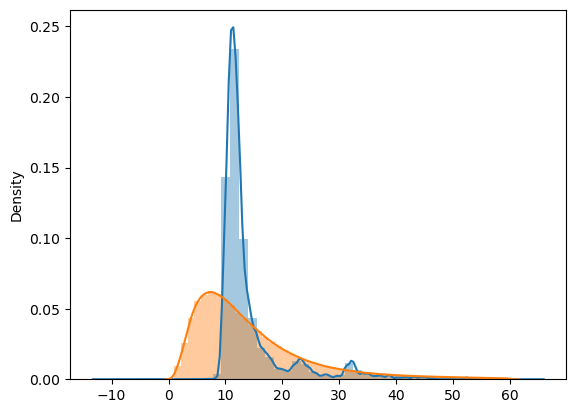

In [65]:
sns.distplot(y_pred, label ='prediction')
sns.distplot(y_train, label ='actual')
plt.legend

In [66]:
mean_squared_error(y_train, y_pred, squared=False)

7.649262060514987

# Q6. Evaluating the model

In [67]:
dir = "/home/jovyan/work/data/yellow/"
filename = "yellow_tripdata_2023-02.parquet"
filepath = os.path.join(dir, filename)

df_val = read_dataframe_remove_outliers(filepath)

In [68]:
categorical = ['PULocationID', 'DOLocationID']
val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [69]:
target = 'duration'
y_val = df_val[target].values

In [70]:
y_pred = lr.predict(X_val)

In [71]:
mean_squared_error(y_val, y_pred, squared=False)

7.811818410552807